## Downloading dataset

In [ ]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od


In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [ ]:
import os

DATA_DIR = './human-faces'
print(os.listdir(DATA_DIR))

['Humans']


In [ ]:
print(os.listdir(DATA_DIR+'/Humans')[:10])

['1 (4263).jpg', '1 (422).jpg', '1 (6013).jpg', '1 (1455).jpg', '1 (5360).jpg', '1 (6572).jpg', '1 (6420).jpg', '1 (3278).jpg', '1 (4846).jpg', '1 (2426).jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
img_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR,transform=T.Compose([
   T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(*stats)]
))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

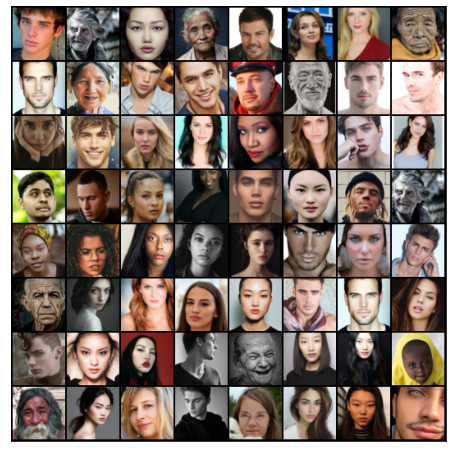

In [ ]:
show_batch(train_dl)


In [ ]:
import torch.nn as nn

## Descriminator

In [ ]:
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.batchnorm import BatchNorm2d
discriminator = nn.Sequential(
    #3*64*64
    nn.Conv2d(3,64,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),
    #64*32*32
    nn.Conv2d(64,128,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    #128*16*16
    nn.Conv2d(128,256,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    #256*8*8
    nn.Conv2d(256,512,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2),
    #512*4*4
    nn.Conv2d(512,1,kernel_size=4,padding=0,stride=1,bias=False),
    #1*1*1

    nn.Flatten(),
    nn.Sigmoid()

)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    #in latent_size*1*1
    nn.ConvTranspose2d(latent_size,512,kernel_size = 4,padding = 0,stride = 1,bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    #512*4*4
    nn.ConvTranspose2d(512,256,kernel_size = 4,padding = 1,stride = 2,bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    #256*8*8
    nn.ConvTranspose2d(256,128,kernel_size = 4,padding = 1,stride = 2,bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    #128*16*16
    nn.ConvTranspose2d(128,64,kernel_size = 4,padding = 1,stride = 2,bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    #64*32*32
    nn.ConvTranspose2d(64,3,kernel_size = 4,padding = 1,stride = 2,bias = False),

    nn.Tanh()
    #3*64*64






)

torch.Size([128, 3, 64, 64])


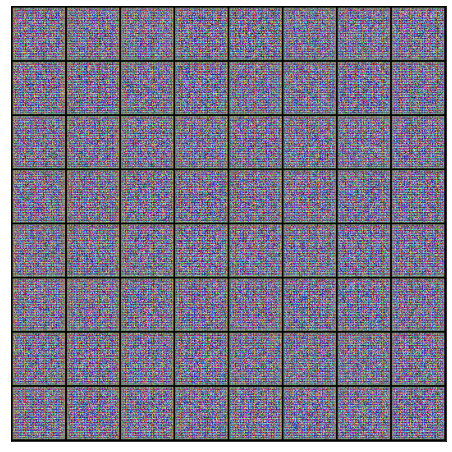

In [ ]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

## Training discriminator

In [ ]:
def train_descriminator(real_images,opt_d):
  opt_d.zero_grad()
  real_pred = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0),1)
  real_loss = F.binary_cross_entropy(real_pred,real_targets)
  real_score = torch.mean(real_pred).item()

  #generate fake images
  latent = torch.randn(batch_size,latent_size,1,1)
  fake_img = generator(latent)

  fake_pred = discriminator(fake_img)
  fake_targets = torch.zeros(fake_img.size(0),1)
  fake_loss = F.binary_cross_entropy(fake_pred,fake_targets)
  fake_score = torch.mean(fake_pred).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(),real_score,fake_score




In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()
  latent = torch.randn(batch_size,latent_size,1,1)
  fake_img = generator(latent)
  fake_pred = discriminator(fake_img)
  fake_targets = torch.ones(fake_img.size(0),1)
  fake_loss = F.binary_cross_entropy(fake_pred,fake_targets)

  fake_loss.backward()
  opt_g.step()

  return fake_loss.item()



In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1)

## Fitting the model


In [ ]:
def fit(lr,epochs,start_idx=1):
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_descriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)




In [ ]:
lr = 0.0002
epochs = 10

In [ ]:
history = fit(lr,epochs)

NameError: ignored

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history


TypeError: ignored

In [ ]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')


In [ ]:
Image('./generated/generated-images-0005.png')